<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<div dir=ltr align=center>

<font color=3C99D size=5>
    Practical Assignment 5 - Reinforcement Learning <br>
<font color=696880 size=4>
    Kiarash Joolaei


# Personal Data

In [1]:
student_number = '401107613'
name = 'Kimia Vanaei'

Our goal in this notebook is to train an agent on game environments such as `FrozenLake-v1` and `Taxi-v3` using reinforcement learning algorithms. The mentioned environments are selected from the `gym` library.

# Introduction to Gym Library

The **Gym** library, developed by OpenAI, is a toolkit for building and evaluating reinforcement learning (RL) algorithms. It provides a variety of predefined environments ranging from simple tasks, like balancing a pole, to complex ones, like playing video games or robotic simulations. Gym's standardized API ensures compatibility with most RL algorithms.

## How Gym Environments Work

### 1. Environment Setup
Each environment represents a specific RL task and is initialized using `gym.make()`.

### 2. Interaction with the Environment
- **Reset the Environment**:
  Use `reset()` to initialize the environment and get the starting state.

- **Take Actions**:
  Use `step(action)` to interact with the environment. This method returns:
  - **Next State**: The resulting state after the action.
  - **Reward**: A scalar feedback signal for the action.
  - **Done**: A boolean indicating if the episode is over.
  - **Info**: Additional diagnostic information.

### 3. Rendering the Environment
Environments can be visualized using `render()` to display the task.

### 4. Closing the Environment
After use, call `close()` to clean up resources.



# Libraries

Import the neccesary libraries here.

In [2]:
import numpy as np
import random
import gym
import time
from IPython.display import clear_output, HTML
import matplotlib.pyplot as plt
from base64 import b64encode
import imageio


The `record_video` and `show_video` functions can visualize the outcome of a sampled trajectory. They will be useful later.

In [3]:
def record_video(env, Qtable, out_directory, fps=1, random_action=False, max_steps=100):
    """
    Record a video of the agent playing the game according to the learned policy.

    Parameters:
    - env: The OpenAI Gym environment.
    - Qtable: The Q-table learned by the agent.
    - out_directory: The file path to save the video.
    - fps: Frames per second in the video.
    - random_action: Whether the agent should take random actions or follow the learned policy.
    - max_steps: Maximum number of steps per episode.

    Returns:
    - total_reward: The total reward earned during the episode.
    """
    images = []
    done = False

    # Handle different gym versions for reset() function
    reset_output = env.reset()
    state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
    info = reset_output[1] if isinstance(reset_output, tuple) else {}

    img = env.render(mode='rgb_array')
    images.append(img)
    total_reward = 0
    i = 0
    while not done:
        i += 1
        if i > max_steps:
            break
        action = np.random.randint(4) if random_action else np.argmax(Qtable[state])
        # Unpack step depending on whether 'truncated' is present
        step_output = env.step(action)
        if len(step_output) == 4:
            state, reward, done, info = step_output  # No truncated field
        else:
            state, reward, done, truncated, info = step_output  # Includes truncated field

        total_reward += reward
        img = env.render(mode='rgb_array')
        images.append(img)
        if not random_action:
            print(f"action: {action}, state: {state}, reward: {reward}, done: {done}, info: {info}")

    # Save the video as an .mp4 file
    video_path = out_directory + "/gameplay.mp4"
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)

    return total_reward, video_path


def show_video(video_path, video_width=300):
    """
    Display the recorded video within a Jupyter notebook.

    Parameters:
    - video_path: The file path to the video.
    - video_width: The width of the video displayed in the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")


# Environment

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles.


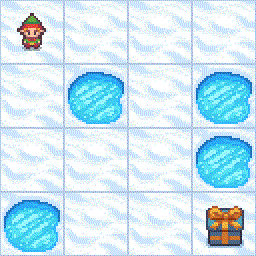


In [4]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
spec = gym.spec('FrozenLake-v1')


print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

state_space = env.observation_space.n
action_space = env.action_space.n

Action Space: Discrete(4)
Observation Space: Discrete(16)
Max Episode Steps: 100
Nondeterministic: False
Reward Range: (0, 1)
Reward Threshold: 0.7



/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Agent

In this section, you should implement the base class `Agent`. All future types of agents will inherit this class.

In [5]:
class Agent:
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Base class for an RL agent.

        Parameters:
        - state_space: int, number of states in the environment.
        - action_space: int, number of actions in the environment.
        - learning_rate: float, initial learning rate for Q-value updates.
        - min_lr: float, minimum value of the learning rate.
        - max_lr: float, maximum value of the learning rate.
        - discount_factor: float, discount factor for future rewards.
        - epsilon: float, initial exploration rate.
        - epsilon_decay: float, rate at which epsilon decays after each episode.
        - epsilon_min: float, minimum value of epsilon.
        - env: the environment in which the agent interacts (optional, needed for Monte Carlo).
        """
        self.env = None
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_space, action_space))

    def choose_action(self, state):
        """
        Choose an action based on the epsilon-greedy policy.

        Parameters:
        - state: int, current state.

        Returns:
        - action: int, chosen action.
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def get_q_value(self, state, action):
        """
        Get the Q-value for the given state-action pair.
        """
        return self.q_table[state, action]

    def decay_epsilon(self):
        """
        Decay the exploration rate (epsilon).
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def decay_lr(self, decay_rate):
        """
        Decay the learning rate within min and max bounds.

        Parameters:
        - decay_rate: float, the factor by which to decay the learning rate.
        """
        self.learning_rate = max(self.min_lr, min(self.max_lr, self.learning_rate * decay_rate))

# Q Learning


**Q-learning** is a model-free reinforcement learning algorithm used to find an optimal policy for an agent interacting with an environment. It uses a Q-table to store the estimated quality (Q-values) of taking specific actions in particular states. The algorithm updates the Q-values iteratively using the Bellman equation:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \big[ r + \gamma \max_a Q(s', a) - Q(s, a) \big]
$$

where $s$ and $a$ are the current state and action, $s'$ is the next state, $r$ is the reward, $\alpha$ is the learning rate, and $\gamma$ is the discount factor. The agent balances exploration (trying new actions) and exploitation (choosing actions with high Q-values) using strategies like the epsilon-greedy policy. Over time, Q-learning converges to the optimal Q-values, allowing the agent to act optimally in the environment.
Here you should implement the `QLearningAgent` class inherited from `Agent`.


In [6]:
class QLearningAgent(Agent):
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-learning agent that extends the base Agent class.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)

    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-value using the Q-learning update rule.

        Parameters:
        - state: int, current state.
        - action: int, action taken.
        - reward: float, reward received.
        - next_state: int, next state.
        - done: bool, whether the episode has terminated.
        """
        curr_value = self.get_q_value(state, action)
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * (0 if done else np.max(self.q_table[next_state])) - curr_value)

# SARSA


**SARSA** (State-Action-Reward-State-Action) is an on-policy reinforcement learning algorithm that learns an optimal policy by updating Q-values based on the agent's experience. Unlike Q-learning, which considers the maximum possible reward from the next state, SARSA updates Q-values using the actual action chosen by the current policy. The update rule is given by:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$. factor. The on-policy nature of SARSA ensures that the updates are consistent with the policy being followed, making it more sensitive to the exploration strategy. Implement the `SARSAAgent` class in a similar manner.


In [7]:
class SARSAAgent(Agent):
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        SARSA agent that extends the base Agent class.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)

    def update(self, state, action, reward, next_state, next_action, done):
        """
        Update the Q-value using the SARSA update rule.

        Parameters:
        - state: int, current state.
        - action: int, action taken.
        - reward: float, reward received.
        - next_state: int, next state.
        - next_action: int, next action taken.
        - done: bool, whether the episode has terminated.
        """
        curr_value = self.get_q_value(state, action)
        self.q_table[state, action] += self.learning_rate * (reward + self.discount_factor * (0 if done else self.get_q_value(next_state, next_action)) - curr_value)

# First Visit Monte Carlo

In this section we're going to do something different. Until now the described algorithms were all of the **Temporal Difference** type. This time we introduce an algorithm called **First Visit Monte Carlo** which relies on long trajectories (episodes) instead of state-action-reward tuples. It works by averaging the returns (cumulative rewards) of the first occurrence of each state in multiple episodes. Unlike dynamic programming, it does not require knowledge of the environment's transition probabilities or rewards. The algorithm proceeds as follows:

1. **Generate Episodes:** Simulate complete episodes of the agent interacting with the environment following a specific policy.
2. **Record Returns:** For each state or state-action pair, calculate the total return $G_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1}$, where $r_{t+k+1}$ is the reward at time $t+k+1$, and $\gamma$ is the discount factor.
3. **Update Values:** For every state (or state-action pair), update its value by averaging the returns from all episodes where it was first visited.

Implement the class for the agent that uses this algorithm. Note that here we need the environment as an input as well.

In [8]:
class MonteCarloAgent(Agent):
    def __init__(self, env, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Monte Carlo agent that extends the base Agent class using the First-Visit Monte Carlo method.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)
        self.env = env
        self.returns = {}
        self.num_returns = {}

    def generate_episode(self):
        """
        Generate an episode (state, action, reward) tuple and return it.

        Returns:
        - episode: list of tuples (state, action, reward), representing the episode's state-action-reward triplets.
        """
        state = self.env.reset()
        episode = []
        done = False

        while not done:
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode


    def update(self, episode):
        """
        Update the Q-values using the First-Visit Monte Carlo method.

        Parameters:
        - episode: list of tuples (state, action, reward), representing the episode's state-action-reward triplets.
        """
        G = 0
        visited = set()

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = reward + self.discount_factor * G

            # First visit -> update only the first occurrence of (state, action) in the episode
            if (state, action) not in visited:
                visited.add((state, action))

                # Update the returns and number of returns
                if (state, action) not in self.returns:
                    self.returns[(state, action)] = G
                    self.num_returns[(state, action)] = 1
                else:
                    self.returns[(state, action)] += G
                    self.num_returns[(state, action)] += 1

                returns_avg = self.returns[(state, action)] / self.num_returns[(state, action)]
                self.q_table[state, action] = (1 - self.learning_rate) * self.get_q_value(state, action) + self.learning_rate * returns_avg


# Training

Implement the `Trainer` class. You can use `isinstance` to check for the type of agent when implementing the training algorithm for them.

In [20]:
class Trainer:
    def __init__(self, agent, env, episodes=1000, max_steps_per_episode=100, lr_decay_rate=0.99):
        """
        Trainer class to handle the training of an RL agent.

        Parameters:
        - agent: instance of an RL agent (e.g., QLearningAgent, SARSAAgent, MonteCarloAgent).
        - env: OpenAI Gym environment.
        - episodes: int, number of episodes to train the agent.
        - max_steps_per_episode: int, maximum steps per episode.
        - lr_decay_rate: float, the rate at which to decay the learning rate.
        """
        self.agent = agent
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.rewards_per_episode = []
        self.lr_decay_rate = lr_decay_rate
        self.env = env if agent.env is None else agent.env

    def train(self):
        """
        Train the agent over the specified number of episodes.
        """
        for episode in range(self.episodes):
            state = self.env.reset()
            total_rewards = 0
            done = False

            if not isinstance(self.agent, MonteCarloAgent):
                action = self.agent.choose_action(state)

            if isinstance(self.agent, MonteCarloAgent):
                episode_data = self.agent.generate_episode()
                self.agent.update(episode_data)
                total_rewards = sum([step[2] for step in episode_data])
            else:
                for step in range(self.max_steps_per_episode):
                    next_state, reward, done, _ = self.env.step(action)
                    total_rewards += reward

                    if isinstance(self.agent, SARSAAgent):
                        next_action = self.agent.choose_action(next_state)
                        self.agent.update(state, action, reward, next_state, next_action, done)
                        action = next_action
                    elif isinstance(self.agent, QLearningAgent):
                        self.agent.update(state, action, reward, next_state, done)
                        action = self.agent.choose_action(next_state)

                    state = next_state

                    if done:
                        break

            self.agent.decay_epsilon()
            self.agent.decay_lr(self.lr_decay_rate)
            self.rewards_per_episode.append(total_rewards)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{self.episodes}: Total Reward: {total_rewards}, Epsilon: {self.agent.epsilon:.4f}, Learning Rate: {self.agent.learning_rate:.4f}")

    def evaluate(self, episodes=100):
        """
        Evaluate the agent's performance over a number of episodes.

        Parameters:
        - episodes: int, number of episodes to evaluate the agent.

        Returns:
        - average_reward: float, average reward over the evaluation episodes.
        """
        total_rewards = 0
        self.agent.epsilon = 0  # Disable exploration during evaluation

        for episode in range(episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False

            for step in range(self.max_steps_per_episode):
                action = self.agent.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state

                if done:
                    break

            total_rewards += episode_reward

        average_reward = total_rewards / episodes
        print(f"Evaluation over {episodes} episodes: Average Reward: {average_reward:.2f}")
        return average_reward


Set the training hyperparameters for each agent. You may need to do some trial and error to find the suitable parameters.

In [22]:
########_____QLearning_____########
learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = QLearningAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900, Learning Rate: 0.8991
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: 0.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: 0.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: 0.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: 0.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: 0.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total Reward: 0.0,

In [26]:
# Evaluate the agent
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.77
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 13, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 2, state: 14, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 13, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 2, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 13, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 2, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 13, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 2, state: 

In [27]:
########_____SARSA_____########


learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = SARSAAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900, Learning Rate: 0.8991
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: 0.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: 0.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: 0.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: 0.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: 0.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total Reward: 0.0,

In [28]:
# Evaluate the agent
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.72
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 8, re

In [31]:
########_____MonteCarlo_____########


learning_rate = 0.9
discount_factor = 0.9
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = MonteCarloAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
    env=env
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900, Learning Rate: 0.8991
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: 0.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: 0.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: 0.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: 0.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: 0.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total Reward: 0.0,

In [32]:
# Evaluate the agent
print("Evaluating the agent...")
trainer.evaluate(episodes=100)


Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.57
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, re

# Which One Wins?!

Now that all the algorithms are implemented, we're going to test them on some other possibly trickier environments. These algorithms may function differently on these environments. Explain which of these algorithms are better for each one of the environments and why. Lastly plot the rewards for `Taxi-v3` environment.

In [33]:
class CustomFrozenLakeEnv(gym.Wrapper):
    def __init__(self, env, hole_reward=-1.0, goal_reward=1.0, step_penalty=0.0):
        super().__init__(env)
        self.hole_reward = hole_reward
        self.goal_reward = goal_reward
        self.step_penalty = step_penalty

    def step(self, action):

        state, reward, done, info = self.env.step(action)

        if done:
            if reward == 1:  # Reached the goal
                reward = self.goal_reward
            else:  # Fell into a hole
                reward = self.hole_reward
        else:
            reward = self.step_penalty  # Penalty for each step

        return state, reward, done, info

original_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env = CustomFrozenLakeEnv(original_env, hole_reward=-1.0, goal_reward=10.0, step_penalty=0.0)

state_space = env.observation_space.n
action_space = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [34]:
########_____QLearning_____########


learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = QLearningAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900, Learning Rate: 0.8991


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: -1.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: -1.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: -1.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: -1.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total Reward: -1.0, Epsilon: 0.8781, Learning Rate: 0.8884
Episode 1400/100000: Total Reward: -1.0, Epsilon

In [35]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 10.00
action: 1, state: 8, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 16, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 24, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 25, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 26, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 27, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 28, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 36, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 37, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 38, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 55, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 63, reward: 10.0, done:

In [36]:
########_____SARSA_____########

learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = SARSAAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900, Learning Rate: 0.8991
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: -1.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: -1.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: -1.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: -1.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total 

In [37]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 10.00
action: 2, state: 1, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 2, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 10, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 11, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 12, reward: 0.0, done: False, info: {'prob': 1.0}
action: 3, state: 4, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 5, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 13, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 14, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 22, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 23, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 31, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: Fal

In [41]:
########_____MonteCarlo_____########

learning_rate = 0.9
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.99999
max_lr = 0.9
min_lr = 0.01



agent = MonteCarloAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
    env=env
)

# Initialize the Trainer
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)


# Train the agent
print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900, Learning Rate: 0.8991
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.8982
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704, Learning Rate: 0.8973
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.8964
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512, Learning Rate: 0.8955
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.8946
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324, Learning Rate: 0.8937
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.9231, Learning Rate: 0.8928
Episode 900/100000: Total Reward: 10.0, Epsilon: 0.9139, Learning Rate: 0.8919
Episode 1000/100000: Total Reward: -1.0, Epsilon: 0.9048, Learning Rate: 0.8910
Episode 1100/100000: Total Reward: -1.0, Epsilon: 0.8958, Learning Rate: 0.8902
Episode 1200/100000: Total Reward: -1.0, Epsilon: 0.8869, Learning Rate: 0.8893
Episode 1300/100000: Total 

In [42]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 10.00
action: 2, state: 1, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 2, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 3, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 4, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 5, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 6, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 14, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 15, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 23, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 31, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 55, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 63, reward: 10.0, done: True

In [43]:
env = gym.make("Taxi-v3")
spec = gym.spec('Taxi-v3')


print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

state_space = env.observation_space.n
action_space = env.action_space.n

qlearning_rewards = []
sarsa_rewards = []

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8



In [79]:
########_____QLearning_____########

learning_rate = 0.99
discount_factor = 0.8
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 25000
max_steps_per_episode = 100
lr_decay_rate = 0.999
max_lr = 0.9
min_lr = 0.01


agent = QLearningAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

qlearning_rewards = trainer.rewards_per_episode

Training the agent...
Episode 100/25000: Total Reward: -451, Epsilon: 0.9900, Learning Rate: 0.8151
Episode 200/25000: Total Reward: -424, Epsilon: 0.9802, Learning Rate: 0.7375
Episode 300/25000: Total Reward: -433, Epsilon: 0.9704, Learning Rate: 0.6673
Episode 400/25000: Total Reward: -433, Epsilon: 0.9608, Learning Rate: 0.6038
Episode 500/25000: Total Reward: -370, Epsilon: 0.9512, Learning Rate: 0.5463
Episode 600/25000: Total Reward: -298, Epsilon: 0.9418, Learning Rate: 0.4943
Episode 700/25000: Total Reward: -415, Epsilon: 0.9324, Learning Rate: 0.4472
Episode 800/25000: Total Reward: -388, Epsilon: 0.9231, Learning Rate: 0.4046
Episode 900/25000: Total Reward: -460, Epsilon: 0.9139, Learning Rate: 0.3661
Episode 1000/25000: Total Reward: -343, Epsilon: 0.9048, Learning Rate: 0.3313
Episode 1100/25000: Total Reward: -406, Epsilon: 0.8958, Learning Rate: 0.2997
Episode 1200/25000: Total Reward: -352, Epsilon: 0.8869, Learning Rate: 0.2712
Episode 1300/25000: Total Reward: -325,

In [80]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 8.08
action: 3, state: 251, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 3, state: 231, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 3, state: 211, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 0, state: 311, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)}
action: 0, state: 411, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 1, 0], dtype=int8)}
action: 4, state: 419, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 1], dtype=int8)}


action: 1, state: 319, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)}
action: 1, state: 219, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 2, state: 239, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 2, state: 259, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 2, state: 279, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 0, state: 379, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 0, state: 479, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 1], dtype=int8)}
action: 5, state: 475, reward: 20, done: True, info: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 1, 0], dtype=int8), 'TimeLimit.truncated': Fa

In [74]:
qlearning_rewards = trainer.rewards_per_episode

In [86]:
########_____SARSA_____########

learning_rate = 0.999
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.0001
episodes = 25000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.999
min_lr = 0.01


agent = SARSAAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()


Training the agent...
Episode 100/25000: Total Reward: -451, Epsilon: 0.9900, Learning Rate: 0.9891
Episode 200/25000: Total Reward: -343, Epsilon: 0.9802, Learning Rate: 0.9792
Episode 300/25000: Total Reward: -280, Epsilon: 0.9704, Learning Rate: 0.9695
Episode 400/25000: Total Reward: -406, Epsilon: 0.9608, Learning Rate: 0.9598
Episode 500/25000: Total Reward: -397, Epsilon: 0.9512, Learning Rate: 0.9503
Episode 600/25000: Total Reward: -343, Epsilon: 0.9418, Learning Rate: 0.9408
Episode 700/25000: Total Reward: -388, Epsilon: 0.9324, Learning Rate: 0.9315
Episode 800/25000: Total Reward: -321, Epsilon: 0.9231, Learning Rate: 0.9222
Episode 900/25000: Total Reward: -361, Epsilon: 0.9139, Learning Rate: 0.9130
Episode 1000/25000: Total Reward: -379, Epsilon: 0.9048, Learning Rate: 0.9039
Episode 1100/25000: Total Reward: -308, Epsilon: 0.8958, Learning Rate: 0.8949
Episode 1200/25000: Total Reward: -334, Epsilon: 0.8869, Learning Rate: 0.8860
Episode 1300/25000: Total Reward: -298,

In [87]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 8.14
action: 0, state: 113, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 2, state: 133, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
action: 0, state: 233, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 2, state: 253, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 2, state: 273, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 0, state: 373, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 0, state: 473, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 1, 0], dtype=int8)}
action: 4, state: 477, reward: -1, done: False, info: {'prob': 1.0, 'ac

In [88]:
sarsa_rewards = trainer.rewards_per_episode

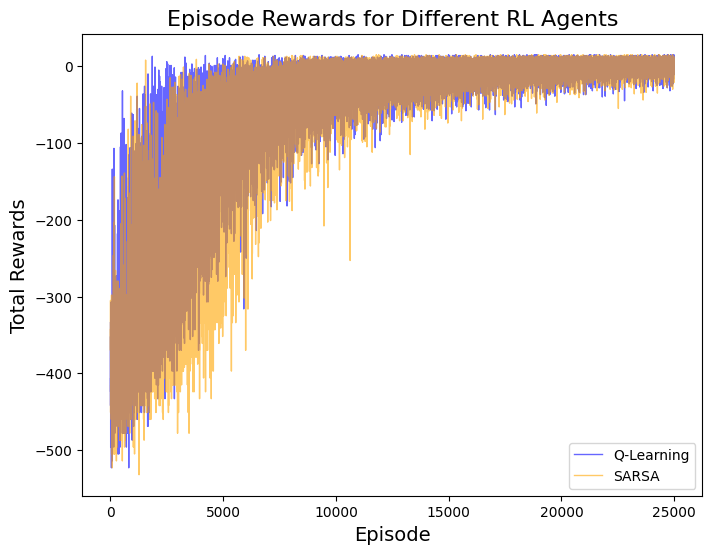

In [89]:
#Plot rewards for SARSA and QLearning agents in taxi-v3 environment

episodes = np.arange(len(qlearning_rewards))

plt.figure(figsize=(8, 6))

plt.plot(episodes, qlearning_rewards, label="Q-Learning", color="blue", alpha=0.6, linewidth=1)
plt.plot(episodes, sarsa_rewards, label="SARSA", color="orange", alpha=0.6, linewidth=1)

plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Rewards", fontsize=14)
plt.title("Episode Rewards for Different RL Agents", fontsize=16)

plt.legend()
plt.show()


Which of these algorithms are better for each environment? Why? (Also It is possible that some algorithms struggle with convergence in some of the environments. Describe why that happens.)

**Answer :**

4x4 Frozen Lake: Q-learning achieved better average rewards and faster convergence than SARSA and Monte Carlo due to its off-policy updates.

8x8 Frozen Lake: Q-learning and SARSA converged similarly, but Q-learning required fewer deviations from the optimal policy during learning. Monte Carlo also performed well, with fewer overall moves, benefiting from its episodic averaging.

Taxi-v3: SARSA performed better than Q-learning, due to its on-policy updates that handle stochastic transitions and penalties more effectively.

Explain what happens if we use the standard 8x8 FrozenLake grid instead of the custom one? Note that the standard environment has a reward +1 for reaching the goal state and rewards of 0 for going to any state other than the goal state.

**Answer :**

The sparse rewards in the standard 8×8 FrozenLake environment make it more challenging for reinforcement learning (RL) algorithms, particularly in terms of exploration. **Q-learning** could be a better choice, but fine-tuning and reward shaping can improve performance for all algorithms.

Compared to other methods, **SARSA** tends to converge more quickly, whereas **Monte Carlo** is more conservative in its approach and requires significantly more time to find an optimal solution.